In [1]:
from api import inoreader_api, inoreader_scraping
import json
import pandas as pd
import re
import random
import pickle

# Scrape feeds starting from a concrete moment and store them in a file.

In [2]:
start_time = 1508112001
feed = 'user/-/label/arXiv'
file_name = 'articles_raw.json'

number_scraped = inoreader_scraping.scrape(feed, start_time, file_name)
print(number_scraped)


Requesting: stream/contents/user/-/label/arXiv
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=Khc1e9o9MtOR
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=ew75EMAN5Ddx
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=4hTbTBeUt11h
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=lBBX8JIL9GKy
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=UUhsWuar3Qrf
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=CPaf5_UfDoco
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=QmGooxrYUSpY
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=HpgfKHdbMXej
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=DNRZU5IX0Tc_
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=lWZbadPMUZ7u
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=uGJgSIN2NQ9C
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=zwOOT6hY_RWq
(200, 'OK')

Requesting: stream/contents/user/-/labe

# Load the feeds from disk.

In [3]:
f = open(file_name, 'r')
json_string = f.read()
f.close

json_object = json.loads(json_string)
all_articles = json_object['all_articles']

In [4]:
def get_abstract_string(abs_dict):
    abs_string = abs_dict['content']
    abs_string = re.search('<p>(.*)</p>', abs_string, flags=re.DOTALL)
    return abs_string.group(1)

In [5]:
def get_canonical_string(canonical_list):
    url_dict = canonical_list[0]
    url = url_dict['href']
    return url

# Create preprocessed and cleaned DataFrame.

In [6]:
all_articles_pd = pd.DataFrame(all_articles)
all_articles_pd = all_articles_pd[['canonical', 'author', 'categories', 'published', 'title', 'summary']]

for i in range(len(all_articles_pd)):
    all_articles_pd['summary'][i] = get_abstract_string(all_articles_pd['summary'][i])
    all_articles_pd['canonical'][i] = get_canonical_string(all_articles_pd['canonical'][i])
    
all_articles_pd['read'] = False
all_articles_pd['liked'] = False

for i in range(len(all_articles_pd)):
    if 'user/1005689817/state/com.google/read' in all_articles_pd['categories'][i]:
        all_articles_pd['read'][i] = True
    if 'user/1005689817/state/com.google/like' in all_articles_pd['categories'][i]:
        all_articles_pd['liked'][i] = True

del all_articles_pd['categories']

/home/piotr.bednarski/ml-env-27-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/piotr.bednarski/ml-env-27-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/piotr.bednarski/ml-env-27-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/piotr.bednarski/ml-env-27-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:15: 

In [7]:
#all_articles_pd

In [8]:
tagged_articles_pd = all_articles_pd[all_articles_pd['read'] == True]

with open('old_articles_proto2.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    old_tagged_articles_pd = pickle.load(f)
    
tagged_articles_pd = pd.concat([tagged_articles_pd, old_tagged_articles_pd])

In [9]:
tagged_articles_unique_pd = tagged_articles_pd.sort_values(by=['canonical', 'liked'], ascending=False).reset_index(drop=True)
to_drop = tagged_articles_unique_pd.duplicated(subset = ['canonical'], keep='first')
to_drop = list(to_drop[to_drop == False].index.values)

tagged_articles_unique_pd = tagged_articles_unique_pd[tagged_articles_unique_pd.index.isin(to_drop)]

In [10]:
print(len(tagged_articles_pd))
print(len(tagged_articles_unique_pd))

2605
2400


In [11]:
X_ = list(tagged_articles_unique_pd['author']+' '+tagged_articles_unique_pd['title']+' '+tagged_articles_unique_pd['summary'])
y_ = list(tagged_articles_unique_pd['liked'])

In [12]:
index_shuffled = [i for i in range(len(X_))]
random.shuffle(index_shuffled)
X = []
y = []
for i in index_shuffled:
    X.append(X_[i])
    y.append(y_[i])

In [13]:
import keras.preprocessing.text
from string import maketrans

def text_to_word_sequence(text,
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                          lower=True, split=" "):
    if lower: text = text.lower()
    if type(text) == unicode:
        translate_table = {ord(c): ord(t) for c,t in zip(filters, split*len(filters)) }
    else:
        translate_table = maketrans(filters, split * len(filters))
    text = text.translate(translate_table)
    seq = text.split(split)
    return [i for i in seq if i]
    
keras.preprocessing.text.text_to_word_sequence = text_to_word_sequence

Using TensorFlow backend.


In [14]:
with open('stopwords/english') as f:
    stopwords = [line.strip() for line in f]

In [15]:
print(len(X[4]))

for i in range(len(X)):
    seq = text_to_word_sequence(X[i])
    clean_seq = [word for word in seq if word not in stopwords]
    X[i] = ' '.join(clean_seq)
    
print(len(X[4]))

1141
888


In [16]:

limit = int(0.8*len(X))
print(limit)

1920


# TFIDF -> NB

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit


model_nb_tfidf = Pipeline([
    ("tfidf_vectorizer", TfidfVectorizer()),\
    ("nb", BernoulliNB())
])


X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

model_nb_tfidf.fit(X_train, y_train)

y_predicted = model_nb_tfidf.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
acc, f1

/home/piotr.bednarski/ml-env-27-gpu/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/piotr.bednarski/ml-env-27-gpu/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0.875, 0.93333333333333335)

In [18]:
y_predicted_proba = model_nb_tfidf.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.15)
y_predicted = (y_predicted_proba[:,1] > 0.10)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)/len(y_predicted)*100.0,"% - ", int(sum(y_predicted)/len(y_predicted)*50.0))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

(0.875, 0.93333333333333335, 0, 480)
(0.0, '% - ', 0)


Rejected 100.00% of wrong ones
Accepted 0.00% of good ones


array([[  1.00000000e+00,   3.15265711e-22],
       [  1.00000000e+00,   2.10592544e-28],
       [  1.00000000e+00,   1.00164309e-28],
       [  1.00000000e+00,   1.33199900e-28],
       [  1.00000000e+00,   2.72014570e-23]])

# CountVect -> NB

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit


model_nb = Pipeline([
    #('vect', CountVectorizer(ngram_range=(1,3),stop_words='english')),\
    ("count_vectorizer", CountVectorizer(analyzer=lambda x: x)),\
    ("nb", BernoulliNB())
])

X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

model_nb.fit(X_train, y_train)

y_predicted = model_nb.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
acc, f1

(0.875, 0.93333333333333335)

In [20]:
y_predicted_proba = model_nb.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.1296)
y_predicted = (y_predicted_proba[:,1] > 0.1325)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print acc, f1, sum(y_predicted), len(y_predicted)
print sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

0.458333333333 0.379190385832 280 480
58.3333333333 % -  29


Rejected 42.86% of wrong ones
Accepted 66.67% of good ones


array([[ 0.79166655,  0.20833345],
       [ 0.92894937,  0.07105063],
       [ 0.84815864,  0.15184136],
       [ 0.89375578,  0.10624422],
       [ 0.84866637,  0.15133363]])

# TFIDF -> SVC

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

model_svc_tfidf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,3), min_df=1, max_df=1.0,stop_words='english')),
    #('vect', CountVectorizer(ngram_range=(3,6),analyzer='char_wb', min_df=10, max_df=0.95,stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ("svc", SVC(kernel='linear', probability=True, class_weight = 'balanced'))
    #("svc", SVC(kernel='linear', probability=True))
])

X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

model_svc_tfidf.fit(X_train, y_train)

y_predicted = model_svc_tfidf.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
acc, f1

(0.875, 0.92236119585112886)

In [22]:
y_predicted_proba = model_svc_tfidf.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > 0.103)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

#(0.62077922077922076, 0.55417162908266104, 162, 385)
#(42.077922077922075, '% - ', 21)
#('Rejected good ones: ', 15, '/', 46)
#('Accepted wrong ones:', 131, '/', 339)
#('Rejected wrong ones: ', 208, '/', 339)
#('Accepted good ones:', 31, '/', 46)

(0.55208333333333337, 0.48045048693926018, 251, 480)
(52.291666666666664, '% - ', 26)


Rejected 51.67% of wrong ones
Accepted 80.00% of good ones


array([[ 0.97249655,  0.02750345],
       [ 0.95833463,  0.04166537],
       [ 0.88755331,  0.11244669],
       [ 0.96457337,  0.03542663],
       [ 0.91175798,  0.08824202]])

In [23]:
(len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/len(y_test)-sum(y_test))


-14.791666666666664

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

model_svc_tfidf = Pipeline([
    #('vect', CountVectorizer(ngram_range=(1,3), min_df=1, max_df=1.0,stop_words='english')),
    ('vect', CountVectorizer(ngram_range=(3,6),analyzer='char_wb', min_df=10, max_df=0.95,stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ("svc", SVC(kernel='linear', probability=True, class_weight = 'balanced'))
    #("svc", SVC(kernel='linear', probability=True))
])

X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

model_svc_tfidf.fit(X_train, y_train)

y_predicted = model_svc_tfidf.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
acc, f1

(0.78749999999999998, 0.77018518518518531)

In [25]:
y_predicted_proba = model_svc_tfidf.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > 0.111)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

#(0.62077922077922076, 0.55417162908266104, 162, 385)
#(42.077922077922075, '% - ', 21)
#('Rejected good ones: ', 15, '/', 46)
#('Accepted wrong ones:', 131, '/', 339)
#('Rejected wrong ones: ', 208, '/', 339)
#('Accepted good ones:', 31, '/', 46)

(0.48958333333333331, 0.41303953475006111, 273, 480)
(56.875, '% - ', 28)


Rejected 45.48% of wrong ones
Accepted 73.33% of good ones


array([[ 0.96256645,  0.03743355],
       [ 0.94595506,  0.05404494],
       [ 0.88653152,  0.11346848],
       [ 0.92424562,  0.07575438],
       [ 0.91255095,  0.08744905]])

# Count -> SVC

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

model_svc = Pipeline([
    #('vect', CountVectorizer()),
    ('vect', CountVectorizer(ngram_range=(1,3), min_df=1, max_df=1.0,stop_words='english')),
    #('vect', CountVectorizer(ngram_range=(3,6),analyzer='char_wb', min_df=10, max_df=0.95,stop_words='english')),
    #('tfidf', TfidfTransformer()),
    ("svc", SVC(kernel='linear', probability=True, class_weight = 'balanced'))
    #("svc", SVC(kernel='linear', probability=True))
])

X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

model_svc.fit(X_train, y_train)

y_predicted = model_svc.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
acc, f1

(0.87708333333333333, 0.92530976937401521)

In [27]:
y_predicted_proba = model_svc.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > 0.11)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

#(0.62077922077922076, 0.55417162908266104, 162, 385)
#(42.077922077922075, '% - ', 21)
#('Rejected good ones: ', 15, '/', 46)
#('Accepted wrong ones:', 131, '/', 339)
#('Rejected wrong ones: ', 208, '/', 339)
#('Accepted good ones:', 31, '/', 46)

(0.51666666666666672, 0.44157726331639385, 262, 480)
(54.583333333333336, '% - ', 27)


Rejected 48.33% of wrong ones
Accepted 75.00% of good ones


array([[ 0.96184194,  0.03815806],
       [ 0.91810116,  0.08189884],
       [ 0.84512951,  0.15487049],
       [ 0.91890093,  0.08109907],
       [ 0.91697881,  0.08302119]])

# Word Embeddings preparation

In [28]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

from keras.models import Sequential
from keras.layers import (Input, Embedding, SimpleRNN, Dense, Activation, TimeDistributed, Bidirectional, LSTM, GaussianNoise)
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.utils import plot_model #Local

In [29]:
DATASETS_DIR = '../ml-research/datasets/'
GLOVE_DIR = DATASETS_DIR+'glove.6B/'
WIKI_EN_DIR = DATASETS_DIR+'wiki.en/'
#embeddings_file = os.path.join(GLOVE_DIR, 'glove.6B.300d.txt')
embeddings_file = os.path.join(WIKI_EN_DIR, 'wiki.en.vec')

# Word embeddings' constraints
MAX_NB_WORDS = 20000  # Number of most common words for tokenizer
EMBEDDING_DIM = 300   # Embeddings dimensionality

In [30]:
import keras.preprocessing.text
from string import maketrans

def text_to_word_sequence(text,
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                          lower=True, split=" "):
    if lower: text = text.lower()
    if type(text) == unicode:
        translate_table = {ord(c): ord(t) for c,t in zip(filters, split*len(filters)) }
    else:
        translate_table = maketrans(filters, split * len(filters))
    text = text.translate(translate_table)
    seq = text.split(split)
    return [i for i in seq if i]
    
keras.preprocessing.text.text_to_word_sequence = text_to_word_sequence

In [31]:
# Tokenizing and creating word index

additional_words = ['unk', 'num']

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X+additional_words)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# inversing the word_index.
index_word = dict((k,v) for v,k in word_index.items())

# example
print(word_index['adversarial'])
print(word_index['unk'])

Found 25513 unique tokens.
81
25512


In [32]:
import models.embedding_matrix as embedding

embedding_matrix = embedding.create_embedding_matrix(embeddings_file, MAX_NB_WORDS, EMBEDDING_DIM, word_index.items())

Indexing word vectors.
Found 2519371 word vectors.
Creating Word Embeddings matrix...
Word Embeddings matrix was successfuly created.


In [33]:
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import (Input, Embedding, SimpleRNN, Dense, Activation, TimeDistributed, Bidirectional,
                          LSTM, GaussianNoise,Conv1D, MaxPooling1D, Flatten, Dropout)
from keras.optimizers import SGD, RMSprop

from keras.models import Model

In [34]:
hyperparameters = {
    'conv_units': 128,
    'hidden_units_1': 128,
    'hidden_units_2': 64,
    'dropout': 0.5,
    'pooling' : 5,
    'gauss_stddev' : 0.0002,
    'epochs' : 15,
    'folds' : 5,
    'nclasses' : 2,
    'max_seq_len' : 300,
    'learning_rate' : 0.001,
    'stopwords' : True
}

hyperparameters = {
    'conv_units': 64,
    'hidden_units_1': 64,
    'hidden_units_2': 32,
    'dropout': 0.5,
    'pooling' : 5,
    'gauss_stddev' : 0.0002,
    'epochs' : 15,
    'folds' : 5,
    'nclasses' : 2,
    'max_seq_len' : 300,
    'learning_rate' : 0.001,
    'stopwords' : True
}

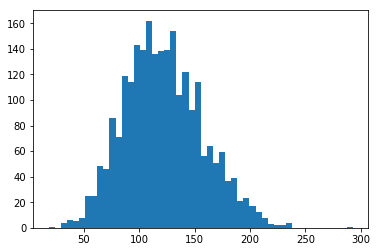

In [35]:
import matplotlib.pyplot as plt

X_sequences = tokenizer.texts_to_sequences(X)
X_sequences_len = []
for item in X_sequences:
    X_sequences_len.append(
                            min( len(item), 1000
                               ))
    
X_sequences_padded = pad_sequences(X_sequences, maxlen=hyperparameters['max_seq_len'])

plt.hist(X_sequences_len, 50)
plt.show()

In [36]:
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(y)

y_num = label_encoder.transform(y)
y_matrix = to_categorical(y_num,hyperparameters['nclasses'])

# CNN

In [37]:
from sklearn.model_selection import KFold
import numpy as np
from keras import backend as K
import utils.evaluation as evaluation
from keras import metrics


class_weight = {0 : 1.,
    1: (len(y)-sum(y))/sum(y)}

acc_list = []
f1_list = []
cm_summed = np.zeros((2,2))
kf = KFold(n_splits=5, shuffle = True)
for train_index, test_index in kf.split(X_sequences):
    K.clear_session()
    
    X_sequences_padded = pad_sequences(X_sequences, maxlen=hyperparameters['max_seq_len'])

    num_words = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]

    embedding_layer = Embedding(num_words,
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=hyperparameters['max_seq_len'],
                                trainable=False)

    # train a 1D convnet with global maxpooling
    sequence_input = Input(shape=(hyperparameters['max_seq_len'],), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    #x = GaussianNoise(hyperparameters['gauss_stddev'])(embedded_sequences)
    x = embedded_sequences
    x = Conv1D(2*hyperparameters['conv_units'], 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(hyperparameters['conv_units'], 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)

    x = Flatten()(x)
    x = Dense(hyperparameters['hidden_units_1'], activation='relu')(x)
    x = Dropout(hyperparameters['dropout'])(x)
    x = Dense(hyperparameters['hidden_units_2'], activation='relu')(x)
    preds = Dense(hyperparameters['nclasses'], activation='softmax')(x)

    model_cnn = Model(sequence_input, preds)
    model_cnn.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[metrics.categorical_accuracy])

    
    X_train, X_test = X_sequences_padded[train_index], X_sequences_padded[test_index]
    y_train, y_test = y_matrix[train_index], y_matrix[test_index]

    # train
    model_cnn.fit(X_train, y_train,
              batch_size=128,
              epochs=hyperparameters['epochs'],
              class_weight=class_weight,
              validation_data=(X_test, y_test))

    # run
    ground_truth = y_test.argmax(1)
    predictions = [list(map(lambda x: x, model_cnn.predict_on_batch(np.asarray([x])).argmax(1)))[0] \
            for x in X_test]
    
    
    acc = evaluation.accuracy(ground_truth, predictions)
    f1 = evaluation.eval_f1_score(ground_truth, predictions)    
    cm = evaluation.cm_matrix(ground_truth, predictions)
    acc_list.append(acc)
    f1_list.append(f1)
    cm_summed = cm_summed + cm
    print(acc, f1)
    print(cm)
    
print(np.asarray(acc).mean(), np.asarray(f1).mean())
print(cm_summed)

Train on 1920 samples, validate on 480 samples
Epoch 1/15
1920/1920 [==============================] - 6s - loss: 1.0998 - categorical_accuracy: 0.7672 - val_loss: 0.6707 - val_categorical_accuracy: 0.8750
Epoch 2/15
1920/1920 [==============================] - 6s - loss: 1.0969 - categorical_accuracy: 0.8484 - val_loss: 0.6347 - val_categorical_accuracy: 0.8750
Epoch 3/15
1920/1920 [==============================] - 6s - loss: 1.0721 - categorical_accuracy: 0.8474 - val_loss: 0.4943 - val_categorical_accuracy: 0.8750
Epoch 4/15
1920/1920 [==============================] - 6s - loss: 1.0767 - categorical_accuracy: 0.7130 - val_loss: 0.5319 - val_categorical_accuracy: 0.8750
Epoch 5/15
1920/1920 [==============================] - 6s - loss: 1.0754 - categorical_accuracy: 0.7031 - val_loss: 0.5468 - val_categorical_accuracy: 0.8208
Epoch 6/15
1920/1920 [==============================] - 6s - loss: 1.0536 - categorical_accuracy: 0.7750 - val_loss: 0.6271 - val_categorical_accuracy: 0.5854

1920/1920 [==============================] - 6s - loss: 0.9860 - categorical_accuracy: 0.8589 - val_loss: 0.5249 - val_categorical_accuracy: 0.8021
Epoch 5/15
1920/1920 [==============================] - 6s - loss: 0.9367 - categorical_accuracy: 0.8516 - val_loss: 0.5683 - val_categorical_accuracy: 0.6813
Epoch 6/15
1920/1920 [==============================] - 6s - loss: 0.8687 - categorical_accuracy: 0.7917 - val_loss: 0.5571 - val_categorical_accuracy: 0.6729
Epoch 7/15
1920/1920 [==============================] - 6s - loss: 0.7642 - categorical_accuracy: 0.7943 - val_loss: 0.7191 - val_categorical_accuracy: 0.5021
Epoch 8/15
1920/1920 [==============================] - 6s - loss: 0.7636 - categorical_accuracy: 0.7557 - val_loss: 0.5772 - val_categorical_accuracy: 0.6729
Epoch 9/15
1920/1920 [==============================] - 6s - loss: 0.5403 - categorical_accuracy: 0.8635 - val_loss: 0.7149 - val_categorical_accuracy: 0.6542
Epoch 10/15
1920/1920 [==============================] - 

In [38]:
ground_truth = y_test.argmax(1)
predictions = [list(map(lambda x: x, model_cnn.predict_on_batch(np.asarray([x]))))[0] \
        for x in X_test]

In [76]:
y_predicted_proba_np = np.asarray(predictions)
#y_predicted = (y_predicted_proba_np[:,1] > 0.001)
y_predicted = (y_predicted_proba_np[:,1] > 0.001)

acc = accuracy_score(y_predicted, ground_truth)
f1 = f1_score(y_predicted, ground_truth, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test[:,0]) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test)[0])))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test[:,0]) & (y_predicted == True)])*100.0/sum(y_test)[0]))

# 15% bezbolesnie odrzucic - 0.000008

y_predicted_proba_np[0:5]

(0.5708333333333333, 0.51009396995376988, 230, 480)
(47.916666666666664, '% - ', 23)


Rejected 33.33% of wrong ones
Accepted 44.61% of good ones


array([[  9.84410644e-01,   1.55893471e-02],
       [  9.87623096e-01,   1.23768579e-02],
       [  1.25291245e-02,   9.87470925e-01],
       [  9.99981284e-01,   1.87653804e-05],
       [  9.98839557e-01,   1.16048940e-03]], dtype=float32)

# LSTM

In [ ]:
hyperparameters = {
    'conv_units': 128,
    'hidden_units_1': 128,
    'hidden_units_2': 64,
    'dropout': 0.5,
    'pooling' : 5,
    'gauss_stddev' : 0.0002,
    'epochs' : 15,
    'folds' : 5,
    'nclasses' : 2,
    'max_seq_len' : 300,
    'learning_rate' : 0.001,
    'stopwords' : True
}

hyperparameters = {
    'conv_units': 64,
    'hidden_units_1': 64,
    'hidden_units_2': 0,
    'dropout': 0.5,
    'pooling' : 5,
    'gauss_stddev' : 0.0002,
    'epochs' : 5,
    'folds' : 5,
    'nclasses' : 2,
    'max_seq_len' : 300,
    'learning_rate' : 0.001,
    'stopwords' : True
}

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
from keras import backend as K
import utils.evaluation as evaluation
from keras import metrics
import time
import sys


class_weight = {0 : 1.,
    1: (len(y)-sum(y))/sum(y)}

acc_list = []
f1_list = []
cm_summed = np.zeros((2,2))
kf = KFold(n_splits=5, shuffle = True)
for train_index, test_index in kf.split(X_sequences):
    K.clear_session()

    num_words = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]
    
    model_lstm = Sequential()
    model_lstm.add(Embedding(num_words,
                                embedding_dim,
                                weights=[embedding_matrix],
                                trainable=False))

    model_lstm.add(Bidirectional(LSTM(hyperparameters['conv_units'], activation='sigmoid', return_sequences=False)))
    model_lstm.add(GaussianNoise(hyperparameters['gauss_stddev']))
    model_lstm.add(Dropout(hyperparameters['dropout']))
    model_lstm.add(Dense(units=hyperparameters['hidden_units_1']))
    if hyperparameters['hidden_units_2'] > 0:
        model_lstm.add(Dense(units=hyperparameters['hidden_units_2']))
    model_lstm.add(Dense(units=hyperparameters['nclasses']))
    model_lstm.add(Activation("softmax"))

    optimizer = RMSprop(lr=hyperparameters['learning_rate'])
    model_lstm.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  #optimizer='adadelta',
                  metrics=['acc'])

    #print(model.summary())
    
    X_train, X_test = np.asarray(X_sequences)[train_index], np.asarray(X_sequences)[test_index]
    y_train, y_test = y_matrix[train_index], y_matrix[test_index]

    # train
    nsentences = len(X_train)
    best_f1 = -np.inf
    for epoch in xrange(hyperparameters['epochs']):
        # Shuffle datasets
        #shuffle([x_train, y_train], 42)
        tic = time.time()
        for i in xrange(nsentences):
            X_lstm = np.asarray([X_train[i]])
            Y_lstm = y_train[i].reshape((1,hyperparameters['nclasses']))
            if X_lstm.shape[1] == 1:
                continue # Bug with X, Y of len 1
            model_lstm.train_on_batch(X_lstm, Y_lstm)
            print '[learning] epoch %i >> %2.2f%%'%(epoch,(i+1)*100./nsentences)+\
                    ' completed in %.2f (sec)\r'%(time.time()-tic),
            sys.stdout.flush()

        # Evaluation // back into the real world : idx -> words
        predictions = [map(lambda x: x, model_lstm.predict_on_batch(np.asarray([x])).argmax(1))[0] \
            for x in X_test]
        ground_truth = y_test.argmax(1)

        f1_valid = evaluation.eval_f1_score(ground_truth, predictions)

        if f1_valid > best_f1:
            best_f1 = f1_valid
            model_lstm.save_weights('best_model_lstm.h5', overwrite=True)
            print 'NEW BEST: epoch', epoch, 'valid F1 = ', f1_valid, 'in', str(time.time()-tic), '(sec)',' '*30

        # load best performing model
        model_lstm.load_weights('best_model_lstm.h5')

    # eval
    ground_truth = y_test.argmax(1)
    predictions = [list(map(lambda x: x, model_lstm.predict_on_batch(np.asarray([x])).argmax(1)))[0] \
            for x in X_test]
    
    
    acc = evaluation.accuracy(ground_truth, predictions)
    f1 = evaluation.eval_f1_score(ground_truth, predictions)    
    cm = evaluation.cm_matrix(ground_truth, predictions)
    acc_list.append(acc)
    f1_list.append(f1)
    cm_summed = cm_summed + cm
    print(acc, f1)
    print(cm)
    
    #break
    #del model
    #K.clear_session()
    
print(np.asarray(acc).mean(), np.asarray(f1).mean())
print(cm_summed)

In [ ]:
ground_truth = y_test.argmax(1)
predictions = [list(map(lambda x: x, model_lstm.predict_on_batch(np.asarray([x]))))[0] \
        for x in X_test]

In [ ]:
y_predicted_proba_np = np.asarray(predictions)
#y_predicted = (y_predicted_proba_np[:,1] > 0.001)
y_predicted = (y_predicted_proba_np[:,1] > 0.4791)

acc = accuracy_score(y_predicted, ground_truth)
f1 = f1_score(y_predicted, ground_truth, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test[:,0]) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test)[0])))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test[:,0]) & (y_predicted == True)])*100.0/sum(y_test)[0]))

# 15% bezbolesnie odrzucic - 0.000008

y_predicted_proba_np[0:5]

# Extree - pretrained

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit
from gensim.models.word2vec import Word2Vec

import models.embedding_matrix as embedding
reload(embedding)

DATASETS_DIR = '../ml-research/datasets/'
WIKI_DIR = DATASETS_DIR+'wiki.pl/'
embeddings_file = WIKI_DIR+'wiki.pl.vec'

word2vec_pretrained = embedding.create_embedding_dictionary(embeddings_file)

# train word2vec on all the texts - both training and test set
# we're not using test labels, just texts so this is fine
model = Word2Vec(X, size=100, window=5, min_count=5, workers=2)
w2v_custom = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

In [ ]:
from collections import defaultdict

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.itervalues().next())
    
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
# and a tf-idf version of the same

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.itervalues().next())
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [ ]:
# Extra Trees classifier is almost universally great, let's stack it with our embeddings

etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(word2vec_pretrained)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=50))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(word2vec_pretrained)), 
                        ("svc", ExtraTreesClassifier(n_estimators=50))])
svc_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(word2vec_pretrained)), 
                        ("extra trees", SVC(kernel="linear", probability=True))])
svc_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(word2vec_pretrained)), 
                        ("svc", SVC(kernel="linear", probability=True))])

In [ ]:
X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

etree_w2v.fit(X_train, y_train)

y_predicted = etree_w2v.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = etree_w2v.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > 0.14)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

In [ ]:
X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

etree_w2v_tfidf.fit(X_train, y_train)

y_predicted = etree_w2v_tfidf.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = etree_w2v_tfidf.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > 0.137)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

In [ ]:
X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

svc_w2v.fit(X_train, y_train)

y_predicted = svc_w2v.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = svc_w2v.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > 0.135)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

In [ ]:
X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

svc_w2v_tfidf.fit(X_train, y_train)

y_predicted = svc_w2v_tfidf.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = svc_w2v_tfidf.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > 0.145)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

# Extree - Custom embeddings

In [ ]:
# Extra Trees classifier is almost universally great, let's stack it with our embeddings

etree_w2v_custom = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v_custom)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=50))])
etree_w2v_tfidf_custom = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v_custom)), 
                        ("svc", ExtraTreesClassifier(n_estimators=50))])
svc_w2v_custom = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v_custom)), 
                        ("extra trees", SVC(kernel="linear", probability=True))])
svc_w2v_tfidf_custom = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v_custom)), 
                        ("svc", SVC(kernel="linear", probability=True))])

In [ ]:
X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

etree_w2v_custom.fit(X_train, y_train)

y_predicted = etree_w2v_custom.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = etree_w2v_custom.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > 0.14)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

In [ ]:
X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

etree_w2v_tfidf_custom.fit(X_train, y_train)

y_predicted = etree_w2v_tfidf_custom.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = etree_w2v_tfidf_custom.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > 0.137)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

In [ ]:
X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

svc_w2v_custom.fit(X_train, y_train)

y_predicted = svc_w2v_custom.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = svc_w2v_custom.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > 0.135)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

In [ ]:
X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

svc_w2v_tfidf_custom.fit(X_train, y_train)

y_predicted = svc_w2v_tfidf_custom.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = svc_w2v_tfidf_custom.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > 0.145)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

# Saving workers

In [ ]:
import types
import tempfile
import keras.models

def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            keras.models.save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = { 'model_str': model_str }
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = keras.models.load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = keras.models.Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__
    

make_keras_picklable()

In [ ]:
def datetime_string():
    localtime = time.localtime(time.time())
    datetime_str = str(localtime.tm_year)
    if(localtime.tm_mon < 10):
        datetime_str += '0'
    datetime_str += str(localtime.tm_mon)
    if(localtime.tm_mday < 10):
        datetime_str += '0'
    datetime_str += str(localtime.tm_mday) + '_'
    if(localtime.tm_hour < 10):
        datetime_str += '0'
    datetime_str += str(localtime.tm_hour)
    if(localtime.tm_min < 10):
        datetime_str += '0'
    datetime_str += str(localtime.tm_min) + '_'
    
    return datetime_str


In [ ]:
from models.model_runner import datetime_string
import dill

contents_dict = {
    'model_cnn_keras' : model_cnn,
    'model_lstm_keras' : model_lstm,
    
    'model_svc_sklearn' : model_svc,
    'model_svc_tfidf_sklearn' : model_svc_tfidf,
    
    'model_nb_sklearn' : model_nb,
    'model_nb_tfidf_sklearn' : model_nb_tfidf,
    
    'etree_w2v_sklearn' : etree_w2v,
    'etree_w2v_tfidf_sklearn' : etree_w2v_tfidf,
    
    'svc_w2v_sklearn' : svc_w2v,
    'svc_w2v_tfidf_sklearn' : svc_w2v_tfidf,
    
    'etree_w2v_custom_sklearn' : etree_w2v_custom,
    'etree_w2v_tfidf_custom_sklearn' : etree_w2v_tfidf_custom,
    
    'svc_w2v_custom_sklearn' : svc_w2v_custom,
    'svc_w2v_tfidf_custom_sklearn' : svc_w2v_tfidf_custom,
    
    'hyperparameters_cnn' : hyperparameters_cnn,
    'hyperparameters_lstm' : hyperparameters_lstm,
    
    'label_encoder' : label_encoder,
    'tokenizer' : tokenizer
}
   
pickle.dump(contents_dict,open( "results/"+datetime_string()+"ensemble_models.pickle", "wb" ) )

etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(word2vec_pretrained)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=50))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(word2vec_pretrained)), 
                        ("svc", ExtraTreesClassifier(n_estimators=50))])
svc_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(word2vec_pretrained)), 
                        ("extra trees", SVC(kernel="linear", probability=True))])
svc_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(word2vec_pretrained)), 
                        ("svc", SVC(kernel="linear", probability=True))])

etree_w2v_custom = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v_custom)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=50))])
etree_w2v_tfidf_custom = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v_custom)), 
                        ("svc", ExtraTreesClassifier(n_estimators=50))])
svc_w2v_custom = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v_custom)), 
                        ("extra trees", SVC(kernel="linear", probability=True))])
svc_w2v_tfidf_custom = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v_custom)), 
                        ("svc", SVC(kernel="linear", probability=True))])